# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance

We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model

Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [2]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [3]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. We will fill a name below as a string (at least 5 characters)

In [4]:
your_name = "Vighnesh" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [5]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [6]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
805,45,female,37.60575,0,no,northwest,7963.813586
1173,38,male,30.72300,2,no,northwest,6651.578702
0,19,female,29.29500,0,yes,southwest,17391.471720
681,19,male,21.31500,0,no,southwest,1279.527800
215,41,female,38.95500,2,no,southwest,7592.925160


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [7]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [8]:
num_cols = len(dataframe.columns)
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [9]:
input_cols = list(dataframe.drop('charges',axis=1).columns)
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [10]:
categorical_cols = list(dataframe.select_dtypes(include='object').columns)
categorical_cols

['sex', 'smoker', 'region']

**Q: What are the column titles of output/target variable(s)?**

In [11]:
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**

In [12]:
# Write your answer here
import numpy as np
# min_charge = np.min(dataframe.charges)
min_charge = dataframe.charges.min()
print("Minimum charge = ",min_charge)
# max_charge = np.max(dataframe.charges)
max_charge = dataframe.charges.max()
print("Maximum charge = ",max_charge)
# avg_charge = np.mean(dataframe.charges)
avg_charge = dataframe.charges.mean()
print("Average charge = ",avg_charge)

Minimum charge =  1155.530117
Maximum charge =  65683.5408503
Average charge =  13674.550305678813


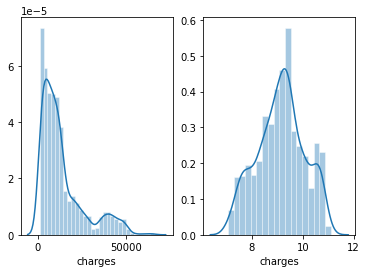

In [13]:
# Plotting the distribution of 'charges' column
import seaborn as sns
fig, axs = plt.subplots(ncols=2)
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
#plt.title("Distribution of charges")
sns.distplot(dataframe.charges, ax=axs[0]) # Skewed data
sns.distplot(np.log(dataframe.charges),ax=axs[1]) # Trying to make data normal using log transformation

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [14]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    #inputs_array = np.array(dataframe1[input_cols])
    inputs_array = dataframe1.drop('charges',axis=1).values
    #targets_array = np.array(dataframe1[output_cols])
    targets_array = dataframe1[['charges']].values
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [15]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
print(inputs_array.shape, targets_array.shape)
inputs_array, targets_array

(1271, 6) (1271, 1)


(array([[45.     ,  0.     , 37.60575,  0.     ,  0.     ,  1.     ],
        [38.     ,  1.     , 30.723  ,  2.     ,  0.     ,  1.     ],
        [19.     ,  0.     , 29.295  ,  0.     ,  1.     ,  3.     ],
        ...,
        [33.     ,  0.     , 35.175  ,  0.     ,  1.     ,  3.     ],
        [53.     ,  1.     , 30.324  ,  0.     ,  0.     ,  1.     ],
        [50.     ,  0.     , 48.3945 ,  1.     ,  0.     ,  2.     ]]),
 array([[ 7963.8135855],
        [ 6651.578702 ],
        [17391.47172  ],
        ...,
        [38191.75316  ],
        [10165.904506 ],
        [ 9836.052053 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [16]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [17]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [18]:
print(inputs,targets)

tensor([[45.0000,  0.0000, 37.6058,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000, 30.7230,  2.0000,  0.0000,  1.0000],
        [19.0000,  0.0000, 29.2950,  0.0000,  1.0000,  3.0000],
        ...,
        [33.0000,  0.0000, 35.1750,  0.0000,  1.0000,  3.0000],
        [53.0000,  1.0000, 30.3240,  0.0000,  0.0000,  1.0000],
        [50.0000,  0.0000, 48.3945,  1.0000,  0.0000,  2.0000]]) tensor([[ 7963.8135],
        [ 6651.5786],
        [17391.4727],
        ...,
        [38191.7539],
        [10165.9043],
        [ 9836.0518]])


Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [19]:
dataset = TensorDataset(inputs, targets)

***Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. ***

In [20]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
print(val_size)
train_size = num_rows - val_size
print(train_size)

train_ds, val_ds = random_split(dataset,[train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

127
1144


In [21]:
print(len(train_ds))
print(len(val_ds))

1144
127


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [22]:
batch_size = 64 # Try to experiment with different batch sizes

In [23]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [24]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[45.0000,  1.0000, 24.0397,  2.0000,  1.0000,  1.0000],
        [19.0000,  0.0000, 38.4038,  0.0000,  0.0000,  1.0000],
        [22.0000,  0.0000, 41.7952,  0.0000,  0.0000,  0.0000],
        [19.0000,  0.0000, 27.0322,  1.0000,  0.0000,  1.0000],
        [27.0000,  1.0000, 34.2142,  3.0000,  0.0000,  0.0000],
        [54.0000,  1.0000, 42.5933,  3.0000,  1.0000,  0.0000],
        [43.0000,  1.0000, 24.3600,  0.0000,  0.0000,  3.0000],
        [60.0000,  1.0000, 30.0247,  0.0000,  0.0000,  0.0000],
        [18.0000,  0.0000, 29.6257,  0.0000,  0.0000,  0.0000],
        [30.0000,  1.0000, 29.0273,  1.0000,  0.0000,  0.0000],
        [34.0000,  1.0000, 45.0450,  1.0000,  0.0000,  3.0000],
        [62.0000,  0.0000, 34.6133,  3.0000,  0.0000,  1.0000],
        [28.0000,  1.0000, 39.9630,  0.0000,  0.0000,  2.0000],
        [33.0000,  0.0000, 37.3065,  0.0000,  1.0000,  1.0000],
        [28.0000,  0.0000, 25.0373,  2.0000,  0.0000,  1.0000],
        [52.0000,  1.0000, 40.53

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression.

In [25]:
input_size = len(input_cols)
print(input_size)
output_size = len(output_cols)
print(output_size)

6
1


In [26]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size) 
        
    def forward(self, xb):
        out = self.linear(xb)                          
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 500 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [27]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [28]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3684,  0.0414, -0.3616, -0.3489,  0.0746,  0.2957]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3785], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [30]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 12003.1806640625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

In [31]:
# model = InsuranceModel() # In case of re-initialization

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [32]:
epochs = 1000
lr = 0.001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 6240.2764
Epoch [1000], val_loss: 6106.4189


In [33]:
epochs = 1500
lr = 0.05
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 5587.8579
Epoch [1000], val_loss: 5520.3887
Epoch [1500], val_loss: 5467.5127


In [34]:
epochs = 2000
lr = 0.1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 5400.7422
Epoch [1000], val_loss: 5366.8809
Epoch [1500], val_loss: 5293.9941
Epoch [2000], val_loss: 5255.5586


In [35]:
epochs = 2500
lr = 0.4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 5143.3389
Epoch [1000], val_loss: 4934.2090
Epoch [1500], val_loss: 4769.5605
Epoch [2000], val_loss: 4593.8115
Epoch [2500], val_loss: 4430.6343


In [36]:
epochs = 3000
lr = 0.8
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 4164.7314
Epoch [1000], val_loss: 3912.3760
Epoch [1500], val_loss: 3528.1680
Epoch [2000], val_loss: 3268.0737
Epoch [2500], val_loss: 2961.0212
Epoch [3000], val_loss: 2786.9907


**Q: What is the final validation loss of your model?**

In [37]:
val_loss = history5[-1]
val_loss

{'val_loss': 2786.99072265625}

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc.

## Step 5: Make predictions using the trained model

In [38]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [39]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 35.3430,  0.0000,  0.0000,  2.0000])
Target: tensor([1170.4913])
Prediction: tensor([858.6514])


In [40]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([47.0000,  0.0000, 37.8000,  1.0000,  0.0000,  3.0000])
Target: tensor([8813.6143])
Prediction: tensor([9118.6387])


In [41]:
input, target = val_ds[13]
predict_single(input, target, model)

Input: tensor([32.0000,  0.0000, 39.0023,  3.0000,  0.0000,  0.0000])
Target: tensor([6524.3740])
Prediction: tensor([6612.6909])


In [42]:
input, target = val_ds[54]
predict_single(input, target, model)

Input: tensor([54.0000,  0.0000, 22.5435,  3.0000,  0.0000,  1.0000])
Target: tensor([12849.6123])
Prediction: tensor([12330.1895])


In [43]:
input, target = val_ds[87]
predict_single(input, target, model)

Input: tensor([42.0000,  0.0000, 24.5385,  0.0000,  1.0000,  0.0000])
Target: tensor([20563.6895])
Prediction: tensor([21377.7363])


Are you happy with your model's predictions? Try to improve them further.